In [1]:
import cobra
from cobra import Reaction, Metabolite, Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.stats import fisher_exact
from operator import itemgetter
import seaborn as sns
import copy

# Load Model

In [53]:
#Putrinas model

#model = cobra.io.load_json_model('data/SI3_iJN1411final_flux_w_rhamnolipid_biosynthesis.json')
#model.objective = model.reactions.BiomassKT2440_WT3.flux_expression
#model.reactions.EX_glyc_e_.lower_bound = 0
#model.reactions.ATPM.bounds = -1,1
#putrinas_model = True

In [5]:
#e-coli model

model = cobra.io.load_json_model('data/iEC1344_C.json')
putrinas_model = False

In [81]:
#Pseudomonas aeruginosa model from https://doi.org/10.1038/s42003-023-04540-8

model = cobra.io.read_sbml_model('data/ISD1509/model.xml')
model.reactions.ATPM.bounds = -10,10
putrinas_model = False

https://doi.org/10.1101/2021.03.10.434463 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


# Biomass optimization for different carbon nutrients

In [6]:
metabolites_txt = re.split('\t|\n',open('data/Metabolites_PM1_PM2A.txt').read())[6:]
PM1_metabolites, PM2a_metabolites = metabolites_txt[1::3], metabolites_txt[2::3]

EX_reactions = []
for rea in model.reactions :
    if rea.id[:2] == 'EX':
        EX_reactions.append(rea.id)

        
def corresponding_reaction(metabolite):
    duplicates = []
    meta = metabolite.replace('a_','').replace('g_','').replace('b_','').replace('Acid','').replace('Two_','').replace('Three_','')
    for nutrient in EX_reactions :    
        if meta.lower() in model.reactions.get_by_id(nutrient).name.lower() :
            duplicates.append(nutrient)
    if metabolite == 'Three_Hydroxy2_Butanone' :
        if putrinas_model :
            duplicates.append('EX_actn_R_e_')    
    
    if len(duplicates) >= 1 :
        return min(duplicates, key = len)
    else :
        return None

carbon_nutrients_EX = []
for metabolite in PM1_metabolites + PM2a_metabolites :
    nutrient = corresponding_reaction(metabolite)
    if not(nutrient is None):
        model.reactions.get_by_id(nutrient).bounds = 0,0 
        carbon_nutrients_EX.append(nutrient)

In [7]:
b = 10

solutions = {nutrient:0 for nutrient in carbon_nutrients_EX}
for nutrient in carbon_nutrients_EX :
    model.reactions.get_by_id(nutrient).bounds = -b, b
    solutions[nutrient] = int(model.slim_optimize()> 1e-3)
    model.reactions.get_by_id(nutrient).bounds = 0, 0

# Comparing with measurment on PA14

In [8]:
def fisher_test(measurment, model_predictions):
    confusion_matrix = np.zeros((2,2))
    for metabolite in measurment.keys():
        nutrient = corresponding_reaction(metabolite)
        if not(nutrient is None):
            confusion_matrix[solutions[nutrient], measurment[metabolite]] += 1
        else :
            confusion_matrix[0, measurment[metabolite]] += 1
    return confusion_matrix, fisher_exact(confusion_matrix).pvalue

def get_formula_EX(nutrient_id):
    return model.metabolites.get_by_id(model.reactions.get_by_id(nutrient_id).reaction[:-5]).name.split('_')[-1]

measurment_xlsx = pd.read_excel('data/raw_data_biolog_Pseudomonas.xlsx')

In [9]:
names = ['PA14', 'PA14.1', 'PA14.3', 'PA14.4']
cm_array = np.zeros((4,2,2))
pvalues_array = np.zeros(4)
ratio = 0.5

for j in range(4):
    control_value_PM1  = measurment_xlsx[names[j]][2]
    measurment_PM1 = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM1 > ratio*control_value_PM1) for i in range(3,98)}
    control_value_PM2a  = measurment_xlsx[names[j]][104]
    measurment_PM2a = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM2a > ratio*control_value_PM2a) for i in range(105,200)}
    cm, pvalue = fisher_test(measurment_PM1 | measurment_PM2a, solutions)
    cm_array[j] = cm
    pvalues_array[j] = pvalue

    print('Strain #{} : pvalue = {}'.format(j+1, pvalue))

Strain #1 : pvalue = 0.4399267089553863
Strain #2 : pvalue = 0.7727510981600499
Strain #3 : pvalue = 0.213839785766234
Strain #4 : pvalue = 0.6124259786052063


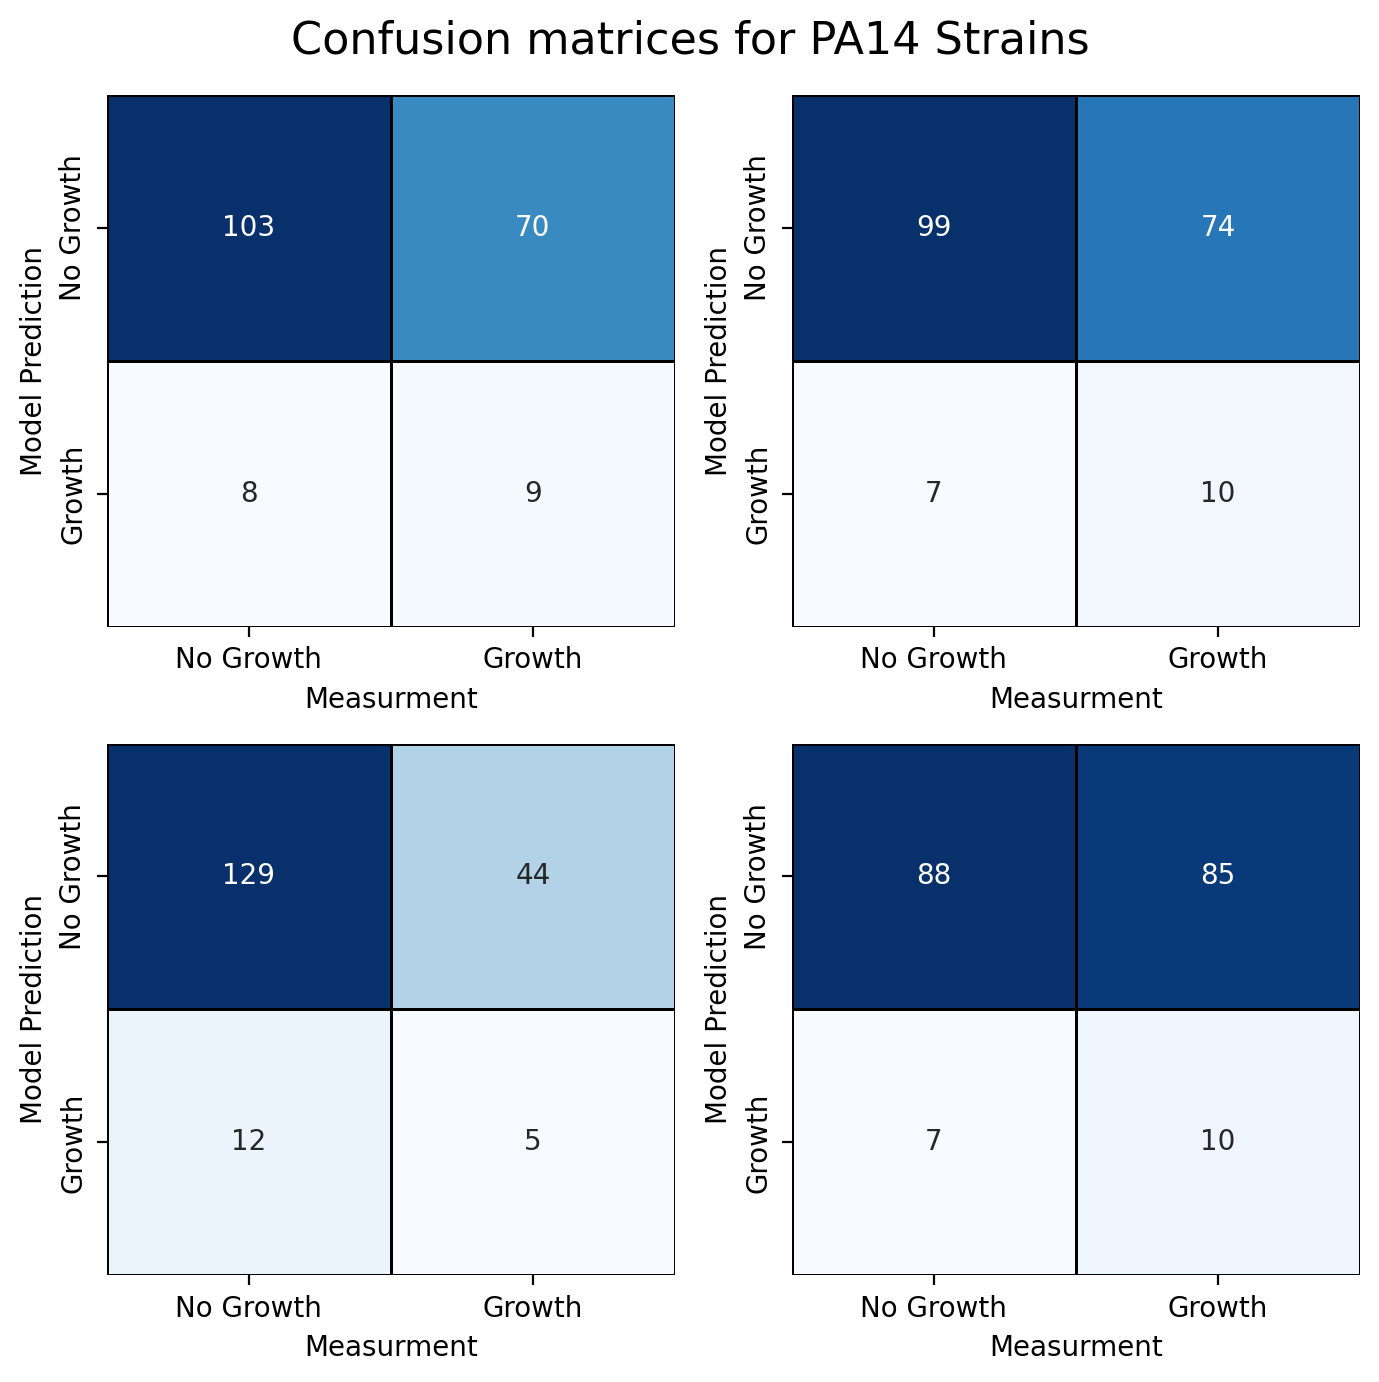

In [10]:
fig, axs= plt.subplots(2,2, figsize=(7,7), dpi = 200)
for i in range(2):
    for j in range(2):
        ax= axs[i,j]
        sns.heatmap(cm_array[i+2*j], annot=True, fmt='g', ax=ax, cbar = False, cmap = 'Blues', linecolor = 'k', linewidth = 0.5)

        ax.set_xlabel('Measurment');ax.set_ylabel('Model Prediction')
        #ax.set_title('Confusion Matrix #{}'.format(i+2*j+1))
        ax.xaxis.set_ticklabels(['No Growth', 'Growth']); ax.yaxis.set_ticklabels(['No Growth', 'Growth'])
fig.suptitle('Confusion matrices for PA14 Strains', fontsize=16)
fig.tight_layout()

[Text(0, 0.5, 'No Growth'), Text(0, 1.5, 'Growth')]

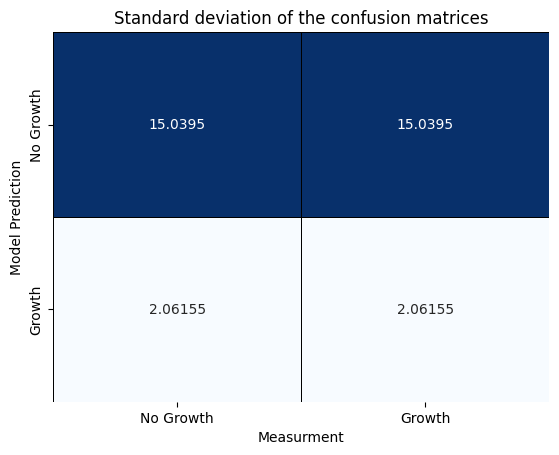

In [11]:
ax = plt.subplot()
sns.heatmap(np.std(cm_array, axis = 0), annot=True, fmt='g', ax=ax, cbar = False, cmap = 'Blues', linecolor = 'k', linewidth = 0.7, vmin = np.min(cm_array), vmax = np.max(cm_array)/10)
ax.set_xlabel('Measurment');ax.set_ylabel('Model Prediction')
ax.set_title('Standard deviation of the confusion matrices')
ax.xaxis.set_ticklabels(['No Growth', 'Growth']); ax.yaxis.set_ticklabels(['No Growth', 'Growth'])

Text(0.5, 1.0, 'Model performance with respect to the choice of threshold')

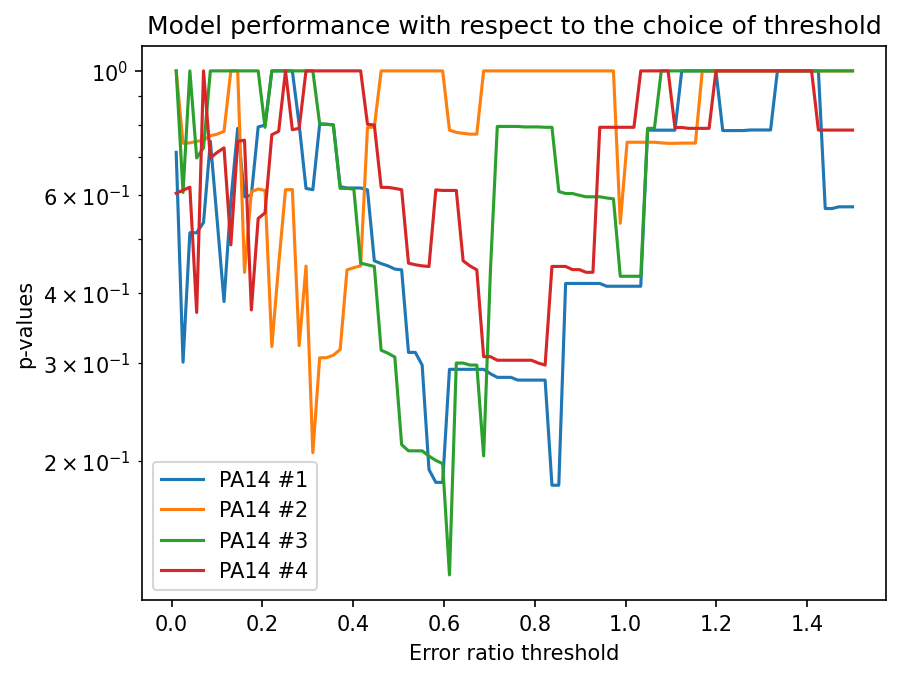

In [12]:
names = ['PA14', 'PA14.2', 'PA14.3', 'PA14.4']

n = 100

ratios = np.linspace(1e-2, 1.5, n)
NG_std = np.zeros(n)
G_std = np.zeros(n)
pvalues_std = np.zeros(n)
pvalues = np.zeros((n,4))


for k, ratio in enumerate(ratios) :
    cm_array = np.zeros((4,2,2))
    pvalues_array = np.zeros(4)
    for j in range(4):
        control_value_PM1  = measurment_xlsx[names[j]][2]
        measurment_PM1 = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM1 > ratio*control_value_PM1) for i in range(3,98)}
        control_value_PM2a  = measurment_xlsx[names[j]][104]
        measurment_PM2a = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM2a > ratio*control_value_PM2a) for i in range(105,200)}

        cm, pvalue = fisher_test(measurment_PM1 | measurment_PM2a, solutions)
        cm_array[j] = cm
        pvalues_array[j] = pvalue
    NG_std[k]= np.std(cm_array, axis = 0)[0,0]
    G_std[k]= np.std(cm_array, axis = 0)[1,1]
    pvalues_std[k]= np.std(pvalues_array)
    pvalues[k] = pvalues_array

plt.figure(dpi = 150)
plt.semilogy(ratios, pvalues, label = ['PA14 #{}'.format(i+1) for i in range(4)])
plt.legend()
plt.xlabel('Error ratio threshold')
plt.ylabel('p-values')
plt.title('Model performance with respect to the choice of threshold')

Text(0.5, 1.0, 'Standard deviation of the confusion matrix')

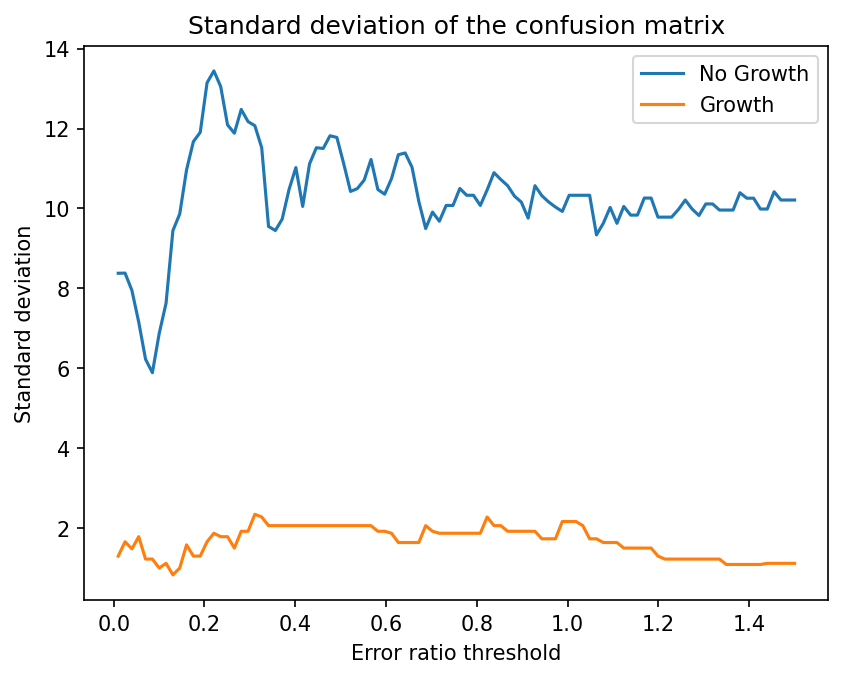

In [13]:
plt.figure(dpi = 150)
plt.plot(ratios, NG_std, label = "No Growth")
plt.plot(ratios, G_std, label = 'Growth')
plt.xlabel('Error ratio threshold')
plt.ylabel('Standard deviation')
plt.legend()
plt.title('Standard deviation of the confusion matrix')

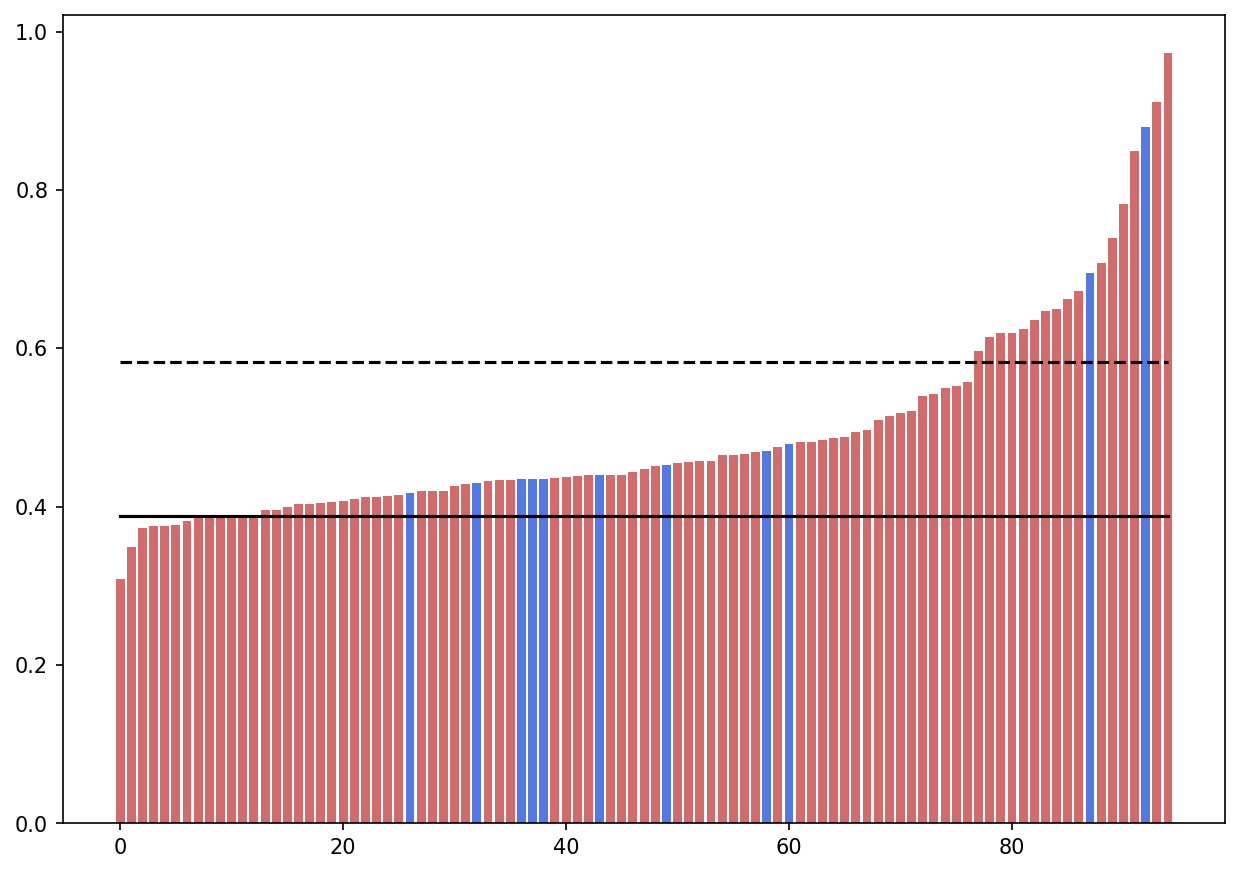

In [17]:
name = 'PA14.1'
ratio = 5e-1

plt.figure(figsize = (10,7), dpi = 150)
colors = []
u = np.sort(np.array(list(measurment_xlsx[name][3:98].items()), dtype = [('order', 'i2'), ('value', 'f4')]), order = 'value')
for e,b in u :
    nutrient = corresponding_reaction(measurment_xlsx['Strain:'][e])
    if nutrient == None :
        colors.append('indianred')
    elif solutions[nutrient] == 0 :
        colors.append('indianred')
    else :
        colors.append('royalblue')

plt.bar(np.arange(95),u['value'], color = colors, alpha = 0.9)
plt.plot(measurment_xlsx[name][2]*np.ones(95), c='k')
plt.plot((1+ratio)*measurment_xlsx[name][2]*np.ones(95), c='k', linestyle = '--')

# Measurment on other strains

Text(0.5, 1.0, 'Model performance with respect to the choice of threshold')

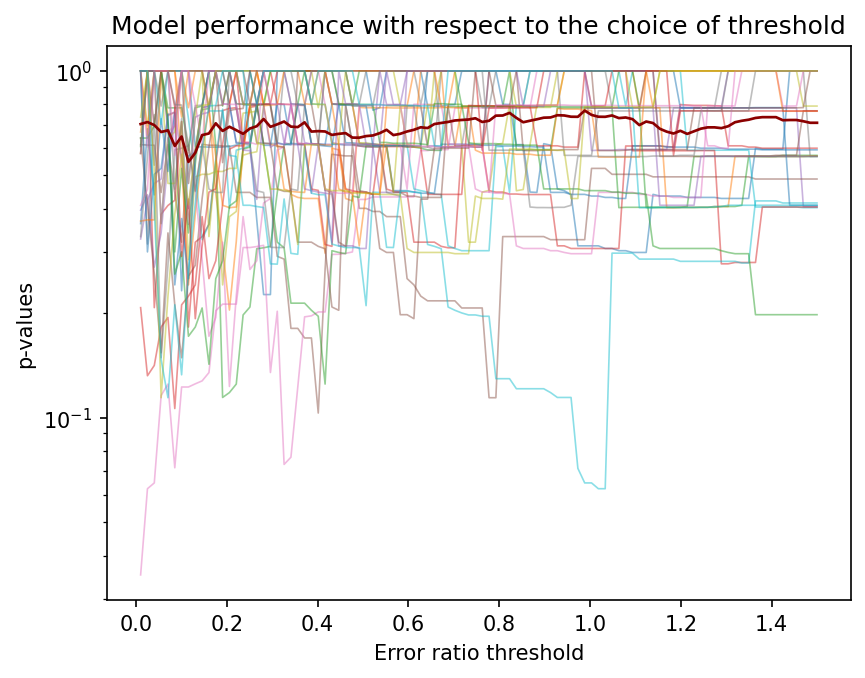

In [18]:
names = list(measurment_xlsx.keys()[9:])

n = 100

ratios = np.linspace(1e-2, 1.5, n)
NG_std = np.zeros(n)
G_std = np.zeros(n)
pvalues_std = np.zeros(n)
pvalues = np.zeros((n,len(names)))


for k, ratio in enumerate(ratios) :
    cm_array = np.zeros((len(names),2,2))
    pvalues_array = np.zeros(len(names))
    for j in range(len(names)):
        control_value_PM1  = measurment_xlsx[names[j]][2]
        measurment_PM1 = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM1 > ratio*control_value_PM1) for i in range(3,98)}
        control_value_PM2a  = measurment_xlsx[names[j]][104]
        measurment_PM2a = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM2a > ratio*control_value_PM2a) for i in range(105,200)}

        cm, pvalue = fisher_test(measurment_PM1 | measurment_PM2a, solutions)
        cm_array[j] = cm
        pvalues_array[j] = pvalue
    NG_std[k]= np.std(cm_array, axis = 0)[0,0]
    G_std[k]= np.std(cm_array, axis = 0)[1,1]
    pvalues_std[k]= np.std(pvalues_array)
    pvalues[k] = pvalues_array

plt.figure(dpi = 150)
plt.semilogy(ratios, pvalues, alpha = 0.5, lw = 0.8)
plt.semilogy(ratios, np.mean(pvalues, axis = 1), c = 'darkred', lw = 1.3)

plt.xlabel('Error ratio threshold')
plt.ylabel('p-values')
plt.title('Model performance with respect to the choice of threshold')

# Gap filling the model

In [19]:
new_model = model.copy()
new_carbon_nutrients_EX = copy.deepcopy(carbon_nutrients_EX)

In [20]:
#Finding the commun missing nutrients to all the strains
names = list(measurment_xlsx.keys()[5:])
ratio = 0.5

control_values_PM1 = {name:measurment_xlsx[name][2] for name in names}
control_values_PM2a = {name:measurment_xlsx[name][104] for name in names}

false_negative_dict = {}

for i, metabolite in enumerate(PM1_metabolites) :
    nutrient = corresponding_reaction(metabolite)
    if nutrient is None :
        false_negative_dict.update({metabolite:0})
        for name in names :
            if measurment_xlsx[name][i+3]- control_values_PM1[name] > ratio*control_values_PM1[name] :
                false_negative_dict[metabolite] += 100/len(names)
        if false_negative_dict[metabolite] == 0 :
            del false_negative_dict[metabolite]

for i, metabolite in enumerate(PM2a_metabolites) :
    nutrient = corresponding_reaction(metabolite)
    if nutrient is None :
        false_negative_dict.update({metabolite:0})
        for name in names :
            if measurment_xlsx[name][i+3]- control_values_PM2a[name] > ratio*control_values_PM2a[name] :
                false_negative_dict[metabolite] += 100/len(names)
        if false_negative_dict[metabolite] == 0 :
            del false_negative_dict[metabolite]

false_negative_array = np.sort(np.array(list(false_negative_dict.items()), dtype=[('x', 'U300'), ('y', 'f4')]), axis = 0, order = 'y')

In [21]:
#Find the missing exchange reactions for metabolites that are already in the model
missing_EX = []
formula_xlsx = pd.read_excel('data/BIOLOG_chemical_formulas.xlsx')

for name,e in false_negative_array[::-1] :
    if e > 50 :
        for meta in model.metabolites :
            if meta.name.split('_')[-1] == formula_xlsx[name][0] :
                if (name.lower() in meta.name.lower()) or (name.replace('_D_','').replace('Two_','').lower() in meta.name.lower()) :
                    print((name, meta.id))
                    missing_EX.append(meta)

In [22]:
for metabolite_c in missing_EX :
    metabolite_e = Metabolite(metabolite_c.id[:-2] + '_e',#
                             name = metabolite_c.name,     #
                             compartment = 'e')
    metabolite_p = Metabolite(metabolite_c.id[:-2] + '_p',#
                             name = metabolite_c.name,     #
                             compartment = 'p')
    EX_reaction = Reaction('EX_'+metabolite_e.id)
    EX_reaction.name = 'R_'+ '_'.join(metabolite_c.name.split('_')[1:-1])+'_exchange'
    EX_reaction.add_metabolites({metabolite_e:-1})
    EX_reaction.bounds = 0, 999999.0
    
    tex_reaction = Reactions(metabolite_e[:-2]+'tex')
    tex_reaction.name = 'R_'+ '_'.join(metabolite_c.name.split('_')[1:-1])+'_transport_via_diffusion__extracellular_to_periplasm_'
    tex_reaction.add_metabolites({metabolite_e:-1, metabolite_p:1})
    tex_reaction.bounds = -999999.0, 999999.0
    
    new_model.add_reactions([EX_reaction, tex_reaction])